In [1]:
# key tpu poligon iRPwbRxfzOrJnd8TAFTMqVv9yPZykrG4Jfy1LObu
# superb-webbing-253413
import math
from glob import glob
import math, os, time, re, json, shutil, pprint, random, sys
import numpy as np
from matplotlib import pyplot as plt
if 'google.colab' in sys.modules: # Colab-only Tensorflow version selector
  %tensorflow_version 2.x
import tensorflow as tf
print("Tensorflow version " + tf.__version__)
AUTO = tf.data.experimental.AUTOTUNE 

from tensorflow.keras.models import Model
from tensorflow.keras.layers import Conv2D, Dropout, BatchNormalization, Input, SeparableConv2D, GlobalAveragePooling2D, Dense, MaxPooling2D, Activation, Flatten
from tensorflow.keras.layers import add as add_concat
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import backend as K

from IPython.display import clear_output
import IPython.display as display

import warnings
warnings.filterwarnings("ignore")
np.random.seed(0)
from google.colab import drive
drive.mount('/content/drive/')

TensorFlow 2.x selected.
Tensorflow version 2.1.0
Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [0]:
from google.colab import auth
auth.authenticate_user()

In [3]:
# Detect hardware
try:
  tpu = tf.distribute.cluster_resolver.TPUClusterResolver() # TPU detection
except ValueError:
  tpu = None
  gpus = tf.config.experimental.list_logical_devices("GPU")
    
# Select appropriate distribution strategy for hardware
if tpu:
  tf.config.experimental_connect_to_cluster(tpu)
  tf.tpu.experimental.initialize_tpu_system(tpu)
  strategy = tf.distribute.experimental.TPUStrategy(tpu)
  print('Running on TPU ', tpu.master())  
elif len(gpus) > 0:
  strategy = tf.distribute.MirroredStrategy(gpus) # this works for 1 to multiple GPUs
  print('Running on ', len(gpus), ' GPU(s) ')
else:
  strategy = tf.distribute.get_strategy() # default strategy that works on CPU and single GPU
  print('Running on CPU')

# How many accelerators do we have ?
print("Number of accelerators: ", strategy.num_replicas_in_sync)

INFO:tensorflow:Initializing the TPU system: 10.124.208.58:8470


INFO:tensorflow:Initializing the TPU system: 10.124.208.58:8470


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Found TPU system:


INFO:tensorflow:Found TPU system:


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


Running on TPU  grpc://10.124.208.58:8470
Number of accelerators:  8


In [4]:
# from google.colab import auth
# auth.authenticate_user()

project_id = 'superb-webbing-253413'
!gcloud config set project {project_id}

# import uuid
# bucket_name = str(uuid.uuid1())  #but i was created bucked
bucket_name = "tpu-poligon-5694642e-6950-11ea-8524-0242ac1c0002"
# # Создать новый бакет
# !gsutil mb gs://{bucket_name}

# # Copy the file to our new bucket.
# !gsutil -m cp -r '/content/drive/My Drive/Colab Notebooks/Bengali_Grapheme/data' gs://{bucket_name}/

# Копи service-495559152420@cloud-tpu.iam.gserviceaccount.com Когда выдает Premission Denaid
!gsutil -m acl -r ch -u service-495559152420@cloud-tpu.iam.gserviceaccount.com:READER gs://{bucket_name}/data/train_tfrecords/
!gsutil -m acl -r ch -u service-495559152420@cloud-tpu.iam.gserviceaccount.com:READER gs://{bucket_name}/data/test_tfrecords/

Updated property [core/project].
No changes to gs://tpu-poligon-5694642e-6950-11ea-8524-0242ac1c0002/data/train_tfrecords/02-128.tfrec
No changes to gs://tpu-poligon-5694642e-6950-11ea-8524-0242ac1c0002/data/train_tfrecords/00-128.tfrec
No changes to gs://tpu-poligon-5694642e-6950-11ea-8524-0242ac1c0002/data/train_tfrecords/01-128.tfrec
No changes to gs://tpu-poligon-5694642e-6950-11ea-8524-0242ac1c0002/data/train_tfrecords/03-128.tfrec
No changes to gs://tpu-poligon-5694642e-6950-11ea-8524-0242ac1c0002/data/train_tfrecords/04-128.tfrec
No changes to gs://tpu-poligon-5694642e-6950-11ea-8524-0242ac1c0002/data/train_tfrecords/05-128.tfrec
No changes to gs://tpu-poligon-5694642e-6950-11ea-8524-0242ac1c0002/data/train_tfrecords/06-128.tfrec
No changes to gs://tpu-poligon-5694642e-6950-11ea-8524-0242ac1c0002/data/train_tfrecords/100-128.tfrec
No changes to gs://tpu-poligon-5694642e-6950-11ea-8524-0242ac1c0002/data/train_tfrecords/1000-128.tfrec
No changes to gs://tpu-poligon-5694642e-6950-1

In [0]:
!export STORAGE_BUCKET=gs://{bucket_name}/
!export TPU_NAME="grpc://10.124.208.58:8470"

In [0]:
PATH_TRAIN = f'gs://{bucket_name}/data/train_tfrecords'
PATH_TEST = f'gs://{bucket_name}/data/test_tfrecords'

In [7]:
if strategy.num_replicas_in_sync == 1: # single GPU or CPU
    BATCH_SIZE = 256
    VALIDATION_BATCH_SIZE = 256
else: # TPU pod
    BATCH_SIZE = 16 * strategy.num_replicas_in_sync
    VALIDATION_BATCH_SIZE = 16 * strategy.num_replicas_in_sync
    
FILENAMES = tf.io.gfile.glob(PATH_TRAIN+'/*.tfrec')
TEST_FILENAMES  = tf.io.gfile.glob(PATH_TEST+'/*.tfrec')

IMAGE_SIZE = [64, 64]
if K.image_data_format() == 'channels_first':
    SHAPE = (3,*IMAGE_SIZE)
else:
    SHAPE = (*IMAGE_SIZE, 3)
SIZE_TFRECORD = 128
split = int(len(FILENAMES)*0.81)
TRAINING_FILENAMES = FILENAMES[:split]
VALIDATION_FILENAMES = FILENAMES[split:]
STEP_PER_EPOCH = ((len(TRAINING_FILENAMES)*SIZE_TFRECORD)//BATCH_SIZE)//2
VALIDATION_STEP_PER_EPOCH = (len(VALIDATION_FILENAMES)*SIZE_TFRECORD)//VALIDATION_BATCH_SIZE
print(len(TRAINING_FILENAMES))
print(len(VALIDATION_FILENAMES))

1271
299


In [0]:
def read_tfrecord(example):
    features = {
      "image": tf.io.FixedLenFeature([], tf.string), 
      "grapheme_root": tf.io.FixedLenFeature([], tf.int64),       
      "vowel_diacritic": tf.io.FixedLenFeature([], tf.int64),       
      "consonant_diacritic": tf.io.FixedLenFeature([], tf.int64),  

      "label":         tf.io.FixedLenFeature([], tf.string),         
      "size":          tf.io.FixedLenFeature([2], tf.int64),     
      "head_root_hot": tf.io.VarLenFeature(tf.float32),
      "head_vowel_hot": tf.io.VarLenFeature(tf.float32),
      "head_consonant_hot": tf.io.VarLenFeature(tf.float32),
    }

    example = tf.io.parse_single_example(example, features)

    image = tf.image.decode_image(example['image'], channels=3)

     
    head_root_hot = tf.sparse.to_dense(example['head_root_hot'])
    head_vowel_hot = tf.sparse.to_dense(example['head_vowel_hot'])
    head_consonant_hot = tf.sparse.to_dense(example['head_consonant_hot'])
    
    head_root_hot = tf.reshape(head_root_hot, [168])
    head_vowel_hot = tf.reshape(head_vowel_hot, [11])
    head_consonant_hot = tf.reshape(head_consonant_hot, [7])

    return image,  {"head_root": head_root_hot, "head_vowel": head_vowel_hot, "head_consonant": head_consonant_hot}
option_no_order = tf.data.Options()
option_no_order.experimental_deterministic = False

def resize_and_crop_image(image, label):
    w = tf.shape(image)[0]
    h = tf.shape(image)[1]
    tw = IMAGE_TARGET[1]
    th = IMAGE_TARGET[0]
    resize_crit = (w * th) / (h * tw)
    image = tf.cond(resize_crit < 1,
                    lambda: tf.image.resize(image, [w*tw/w, h*tw/w]), # if true
                    lambda: tf.image.resize(image, [w*th/h, h*th/h])  # if false
                   )
    nw = tf.shape(image)[0]
    nh = tf.shape(image)[1]
    image = tf.image.crop_to_bounding_box(image, (nw - tw) // 2, (nh - th) // 2, tw, th)
    return image, label

def normalize(image, label):
    image = tf.reshape(image, [*IMAGE_SIZE, 3])
    image = tf.cast(image, tf.float32)/255.0 
    # image = tf.image.per_image_standardization(image)
    return image, label


def augmentation(image, label):
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_flip_up_down(image)
    # image = tf.image.rot90(image, k=random.randrange(4))
    image = tf.image.random_saturation(image, 0, 2)
    image = tf.image.random_hue(image, 0.08)
    image = tf.image.random_contrast(image, 0.7, 1.3)
    image = tf.image.random_brightness(image, 0.15)
    return image, label


def force_image_sizes(dataset):
    reshape_images = lambda image, label: (tf.reshape(image, SHAPE), label)   
    dataset = dataset.map(reshape_images, num_parallel_calls=AUTO)
    return dataset

def load_dataset(filenames):
    ignore_order = tf.data.Options()
    ignore_order.experimental_deterministic = False
    dataset = tf.data.TFRecordDataset(filenames, num_parallel_reads=AUTO) 
    dataset = dataset.with_options(ignore_order)
    dataset = dataset.map(read_tfrecord, num_parallel_calls=AUTO)
#     dataset = dataset.map(resize_and_crop_image, num_parallel_calls=AUTO)
    return dataset


def get_training_dataset():
    dataset = load_dataset(TRAINING_FILENAMES)
    # dataset = dataset.map(augmentation, num_parallel_calls=AUTO)
    dataset = dataset.map(normalize, num_parallel_calls=AUTO)
    dataset = force_image_sizes(dataset)
    dataset = dataset.repeat()
    dataset = dataset.shuffle(2000)
    dataset = dataset.batch(BATCH_SIZE)
    dataset = dataset.prefetch(AUTO)
    return dataset

def get_validation_dataset():
    dataset = load_dataset(VALIDATION_FILENAMES)
    dataset = dataset.map(normalize, num_parallel_calls=AUTO)
    dataset = force_image_sizes(dataset)
    dataset = dataset.batch(VALIDATION_BATCH_SIZE)
    dataset = dataset.prefetch(AUTO) 
    return dataset

In [0]:
import os
# Matplotlib config
plt.ioff()
plt.rc('image', cmap='gray_r')
plt.rc('grid', linewidth=1)
plt.rc('xtick', top=False, bottom=False, labelsize='large')
plt.rc('ytick', left=False, right=False, labelsize='large')
plt.rc('axes', facecolor='F8F8F8', titlesize="large", edgecolor='white')
plt.rc('text', color='a8151a')
plt.rc('figure', facecolor='F0F0F0', figsize=(16,9))
# Matplotlib fonts
MATPLOTLIB_FONT_DIR = os.path.join(os.path.dirname(plt.__file__), "mpl-data/fonts/ttf")

def plot_learning_rate(lr_func, epochs):
    xx = np.arange(epochs+1, dtype=np.float)
    y = [lr_decay(x) for x in xx]
    fig, ax = plt.subplots(figsize=(9, 6))
    ax.set_xlabel('epochs')
    ax.set_title('Learning rate\ndecays from {:0.3g} to {:0.3g}'.format(y[0], y[-2]))
    ax.minorticks_on()
    ax.grid(True, which='major', axis='both', linestyle='-', linewidth=1)
    ax.grid(True, which='minor', axis='both', linestyle=':', linewidth=0.5)
    ax.step(xx,y, linewidth=3, where='post')
    display.display(fig)

class PlotTraining(tf.keras.callbacks.Callback):
    def __init__(self, sample_rate=1, zoom=1):
        self.sample_rate = sample_rate
        self.step = 0
        self.zoom = zoom
        self.steps_per_epoch = STEP_PER_EPOCH

    def on_train_begin(self, logs={}):
        self.batch_history = {}
        self.batch_step = []
        self.epoch_history = {}
        self.epoch_step = []
        self.fig, self.axes = plt.subplots(3, 2, figsize=(19, 19))
        self.fig.subplots_adjust(wspace=0.3, hspace=0.25)
        plt.ioff()
      
        
    def on_batch_end(self, batch, logs={}):
        if (batch % self.sample_rate) == 0:
            self.batch_step.append(self.step)
            for k,v in logs.items():
              # do not log "batch" and "size" metrics that do not change
              # do not log training accuracy "acc"
                if k=='batch' or k=='size' or k == 'loss':# or k=='acc':
                    continue
                self.batch_history.setdefault(k, []).append(v)
        self.step += 1

    def on_epoch_end(self, epoch, logs={}):
        plt.close(self.fig)
        for axes in self.axes:
            axes[0].cla()
            axes[1].cla()

            axes[0].set_ylim(0, 1.2/self.zoom)
            axes[1].set_ylim(1-1/self.zoom/2, 1+0.1/self.zoom/2)
    
        self.epoch_step.append(self.step)
        for k,v in logs.items():
          # only log validation metrics
            if not k.startswith('val_') or k == 'val_loss':
                continue
            self.epoch_history.setdefault(k, []).append(v)

        display.clear_output(wait=True)
        
        for count, (k,v) in enumerate(self.batch_history.items()):
            if count <= 2:
                self.axes[count][0].plot(np.array(self.batch_step) / self.steps_per_epoch, v, label='{}: {:.3f}'.format(k, v[len(v)-1]))
            else:
                self.axes[count-3][1].plot(np.array(self.batch_step) / self.steps_per_epoch, v, label='{}: {:.3f}'.format(k, v[len(v)-1]))
      
        for count, (k,v) in enumerate(self.epoch_history.items()):
            if count <= 2:
                self.axes[count][0].plot(np.array(self.epoch_step) / self.steps_per_epoch, v, label='{}: {:.3f}'.format(k, v[epoch]), linewidth=3)
            else:
                self.axes[count-3][1].plot(np.array(self.epoch_step) / self.steps_per_epoch, v, label='{}: {:.3f}'.format(k, v[epoch]), linewidth=3)
        for axes in self.axes:
            axes[0].legend()
            axes[1].legend()
            axes[0].set_xlabel('epochs')
            axes[1].set_xlabel('epochs')
            axes[0].minorticks_on()
            axes[0].grid(True, which='major', axis='both', linestyle='-', linewidth=1)
            axes[0].grid(True, which='minor', axis='both', linestyle=':', linewidth=0.5)
            axes[1].minorticks_on()
            axes[1].grid(True, which='major', axis='both', linestyle='-', linewidth=1)
            axes[1].grid(True, which='minor', axis='both', linestyle=':', linewidth=0.5)
        display.display(self.fig)

In [0]:
training_dataset = get_training_dataset()
validation_dataset = get_validation_dataset()


In [11]:
with strategy.scope():
    bnmomemtum=0.8
    def fire(x, filters, kernel_size):
        if not isinstance(filters, list): 
            filters = [filters, filters]  
        x = SeparableConv2D(filters[0], kernel_size, padding='same', use_bias=False)(x)
        x = BatchNormalization(axis=channel_axis, center=True, scale=False, momentum=bnmomemtum)(x)
        x = Activation('relu')(x)
        x = SeparableConv2D(filters[1], kernel_size, padding='same', use_bias=False)(x)
        return BatchNormalization(axis=channel_axis, center=True, scale=False, momentum=bnmomemtum)(x)
    
    def fire_module_separable_conv(filters, kernel_size=(3, 3)):
        return lambda x: fire(x, filters, kernel_size)
    
    channel_axis = 1 if K.image_data_format() == 'channels_first' else -1
    img_input = Input(shape=SHAPE)

    x = Conv2D(32, (3, 3), strides=(2, 2), use_bias=False)(img_input)
    x = BatchNormalization(axis=channel_axis, center=True, scale=False, momentum=bnmomemtum)(x)
    x = Activation('relu')(x)

    x = Conv2D(64, (3, 3), use_bias=False, name='block1_conv2')(x)
    x = BatchNormalization(axis=channel_axis, center=True, scale=False, momentum=bnmomemtum)(x)
    x = Activation('relu')(x)

    residual = Conv2D(128, (1, 1), strides=(2, 2), padding='same', use_bias=False)(x)
    residual = BatchNormalization(axis=channel_axis, center=True, scale=False, momentum=bnmomemtum)(residual)

    x = fire_module_separable_conv(128)(x)

    x = MaxPooling2D((3, 3), strides=(2, 2), padding='same')(x)
    x = add_concat([x, residual])

    residual = Conv2D(256, (1, 1), strides=(2, 2), padding='same', use_bias=False)(x)
    residual = BatchNormalization(axis=channel_axis, center=True, scale=False, momentum=bnmomemtum)(residual)

    x = Activation('relu')(x)
    x = fire_module_separable_conv(256)(x)

    x = MaxPooling2D((3, 3), strides=(2, 2), padding='same')(x)
    x = add_concat([x, residual])

    for i in range(4):
        residual = x

        x = Activation('relu')(x)
        x = SeparableConv2D(256, (3, 3), padding='same', use_bias=False)(x)
        x = BatchNormalization(axis=channel_axis, center=True, scale=False, momentum=bnmomemtum)(x)
        x = Activation('relu')(x)
        x = fire_module_separable_conv(256)(x)
        
        x = add_concat([x, residual])


    x = fire_module_separable_conv([728, 1024])(x)
    x = Activation('relu')(x)
    y = GlobalAveragePooling2D()(x)
    
    # y = Dense(1536)(y)
    # y = Activation('relu')(y)
    # y = Dropout(0.33)(y)
    
    y = Dense(1536)(y)
    y = Activation('relu')(y)
    y = Dropout(0.33)(y)
    
    head_root = Dense(168, activation = 'softmax', name='head_root')(y)
    head_vowel = Dense(11, activation = 'softmax', name='head_vowel')(y)
    head_consonant = Dense(7, activation = 'softmax', name='head_consonant')(y)
   
    model = Model(inputs=img_input, outputs=[head_root, head_vowel, head_consonant]) 
    
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 64, 64, 3)]  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 31, 31, 32)   864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 31, 31, 32)   96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 31, 31, 32)   0           batch_normalization[0][0]        
______________________________________________________________________________________________

0.0001 0.004654183641433716


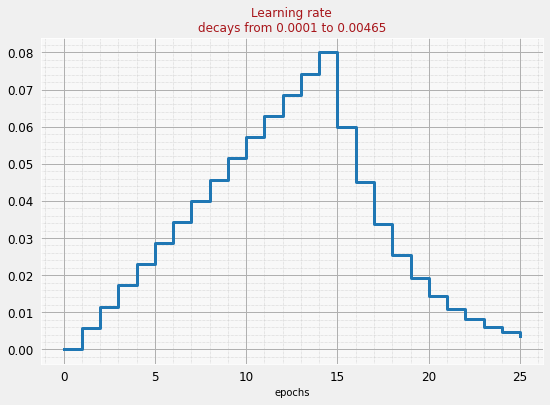

In [12]:
if strategy.num_replicas_in_sync == 1: # single GPU
    start_lr =  0.0001
    min_lr = 0.000158
    max_lr = 0.01 * strategy.num_replicas_in_sync
    rampup_epochs = 14
    sustain_epochs = 0
    exp_decay = .75
else: # TPU pod
    start_lr =  0.0001
    min_lr = 0.000158
    max_lr = 0.01 * strategy.num_replicas_in_sync
    rampup_epochs = 14
    sustain_epochs = 0
    exp_decay = .75

EPOCHS=25

def lr_decay(epoch):
    def lr(epoch, start_lr, min_lr, max_lr, rampup_epochs, sustain_epochs, exp_decay):
        if epoch < rampup_epochs:
            lr = (max_lr - start_lr)/rampup_epochs * epoch + start_lr
        elif epoch < rampup_epochs + sustain_epochs:
            lr = max_lr
        else:
            lr = (max_lr - min_lr) * exp_decay**(epoch-rampup_epochs-sustain_epochs) + min_lr
        return lr
    return lr(epoch, start_lr, min_lr, max_lr, rampup_epochs, sustain_epochs, exp_decay)
    
lr_decay_callback = tf.keras.callbacks.LearningRateScheduler(lambda epoch: lr_decay(epoch), verbose=True)

rng = [i for i in range(EPOCHS)]
y = [lr_decay(x) for x in rng]
plt.plot(rng, [lr_decay(x) for x in rng])
print(y[0], y[-1])
plot_learning_rate(lr_decay_callback, EPOCHS)

In [0]:
plot_training = PlotTraining(sample_rate=10, zoom=1)
callbacks_list = [plot_training, lr_decay_callback]  

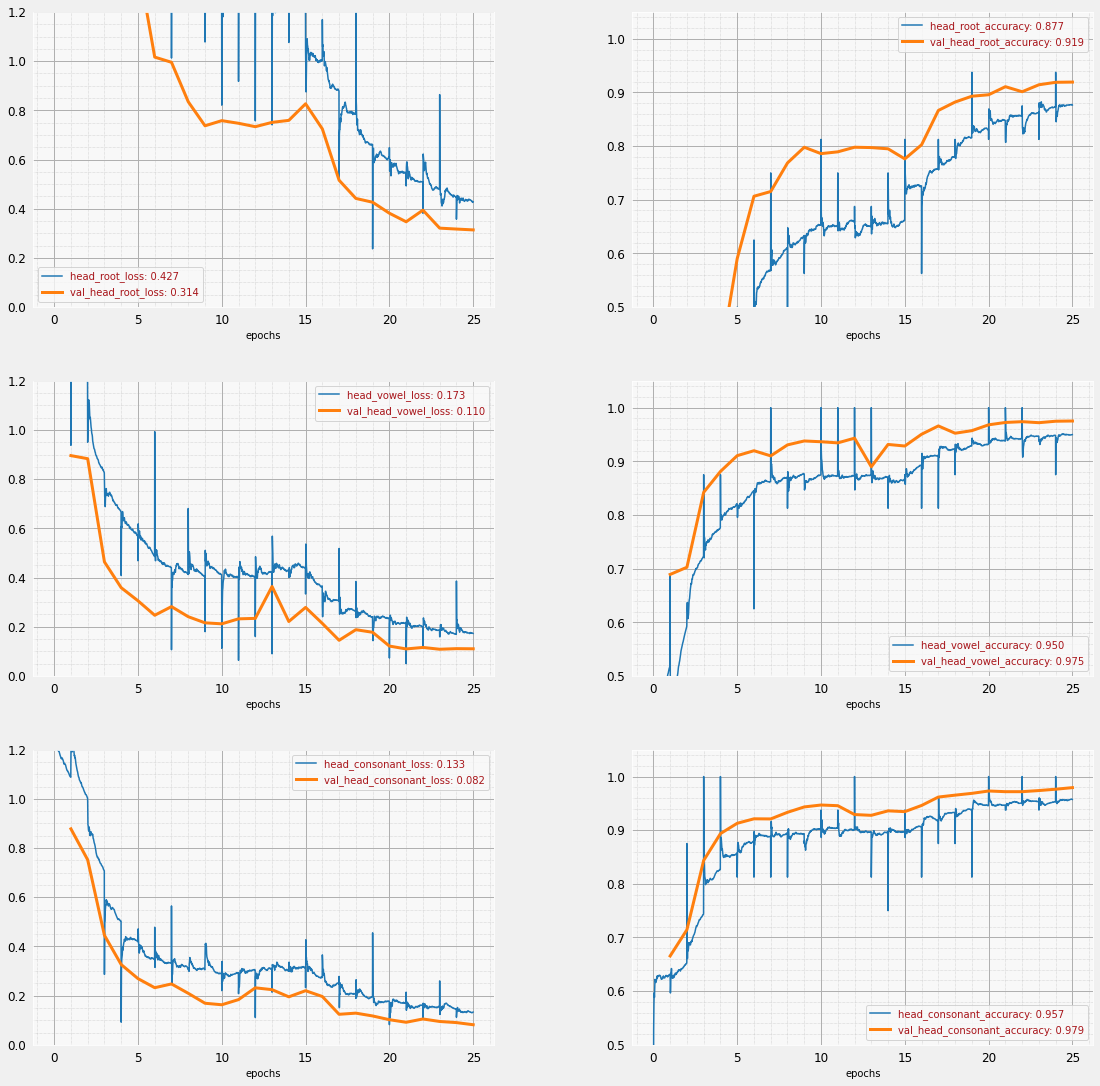

635/635 [==============================] - 49s 77ms/step - loss: 0.7331 - head_root_loss: 0.4284 - head_vowel_loss: 0.1731 - head_consonant_loss: 0.1358 - head_root_accuracy: 0.8766 - head_vowel_accuracy: 0.9496 - head_consonant_accuracy: 0.9571 - val_loss: 0.5222 - val_head_root_loss: 0.3137 - val_head_vowel_loss: 0.1103 - val_head_consonant_loss: 0.0816 - val_head_root_accuracy: 0.9193 - val_head_vowel_accuracy: 0.9751 - val_head_consonant_accuracy: 0.9793


In [14]:
history = model.fit(
    training_dataset, 
    steps_per_epoch=STEP_PER_EPOCH, 
    epochs=EPOCHS,
    validation_data=validation_dataset,
    validation_steps=VALIDATION_STEP_PER_EPOCH,
    callbacks=callbacks_list)